In [1]:
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score, cross_validate

In [3]:
import xgboost as xgb
from sklearn.svm import SVR, LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso

In [4]:
f = pd.read_csv('C:\\Users\\Tan\\Documents\\Data projects\\Stack time series\\beijing_engineered.csv')
df = pd.DataFrame(f)

In [5]:
df

,pm25,dewp,temp,cws,target,cbwd_1,cbwd_2,cbwd_3,clunar,cstorm,...,chour_16.0,chour_17.0,chour_18.0,chour_19.0,chour_20.0,chour_21.0,chour_22.0,chour_23.0,pm25_1,pm25_2
0,159,-11,-5,3,181,0,0,0,0,0,...,0,0,0,0,0,0,0,0,148,129
1,181,-7,-5,5,138,0,0,0,0,0,...,0,0,0,0,0,0,0,0,159,148
2,138,-7,-5,6,109,0,0,0,0,0,...,0,0,0,0,0,0,0,0,181,159
3,109,-7,-6,7,105,0,0,0,0,0,...,0,0,0,0,0,0,0,0,138,181
4,105,-7,-6,8,124,0,0,0,0,0,...,0,0,0,0,0,0,0,0,109,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43792,10,-22,-2,226,8,0,1,0,0,0,...,0,0,0,1,0,0,0,0,9,8
43793,8,-23,-2,231,10,0,1,0,0,0,...,0,0,0,0,1,0,0,0,10,9
43794,10,-22,-3,237,10,0,1,0,0,0,...,0,0,0,0,0,1,0,0,8,10
43795,10,-22,-3,242,8,0,1,0,0,0,...,0,0,0,0,0,0,1,0,10,8


In [6]:
df['date'] = pd.to_datetime(df.date)

In [7]:
# Setting DateTime index
df['date'] = pd.to_datetime(df.date)
df.set_index('date', inplace=True)

In [8]:
df[['pm25', 'target']].describe()

,pm25,target
count,43797.000000,43797.000000
mean,98.025367,98.022011
std,90.522403,90.522867
min,0.000000,0.000000
25%,30.000000,30.000000
50%,74.000000,74.000000
75%,134.000000,134.000000
max,994.000000,994.000000


In [9]:
# Check for any NaN or infinite values across rows
df[df.isin([np.nan, np.inf, -np.inf]).any(axis=1)].count().sum()

0

# Subsetting Data Into 3 Consecutive Sections

For a two-step stacked time-series model where the **temporal order** of the data need to be followed strictly, we split the data into **three time-ordered batches**. 

The first (earliest in time) batch (let's call it the **base-training set**) is for the Gridsearch **hyper-parameter tuning of the base models**. 

The optimized base models then make **out-of-sample predictions** on the next batch of data, which is used to **train the meta model** (let's call this the **meta-training set**).

The fitted meta model then makes **out-of-sample predictions** on the final batch of data, which is used for scoring the models' performance (let's call this the **holdout test set**).

In [10]:
# Extract the last 10% of observations as the holdout-test set
df_holdout = df.iloc[-4380:]
df_rest = df.iloc[:-4380]

In [11]:
y_test = df_holdout.pop('target')

In [12]:
y = df_rest.pop('target')

In [13]:
X = df_rest

The remaining **pre-holdout data** is split into **2/3 base-training and 1/3 meta-training sets**.

In [14]:
c = len(y)/3

In [15]:
# Data is organized in declining chronological order
y_meta = y[-int(c):]
y_base = y[:-int(c)]

In [16]:
X_meta = X[-int(c):]
X_base = X[:-int(c)]

In [17]:
df_holdout.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4380 entries, 2014-07-02 11:00:00 to 2014-12-31 22:00:00
Data columns (total 47 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   pm25         4380 non-null   int64
 1   dewp         4380 non-null   int64
 2   temp         4380 non-null   int64
 3   cws          4380 non-null   int64
 4   cbwd_1       4380 non-null   int64
 5   cbwd_2       4380 non-null   int64
 6   cbwd_3       4380 non-null   int64
 7   clunar       4380 non-null   int64
 8   cstorm       4380 non-null   int64
 9   cwkend       4380 non-null   int64
 10  nord_cws     4380 non-null   int64
 11  cmonth_2.0   4380 non-null   int64
 12  cmonth_3.0   4380 non-null   int64
 13  cmonth_4.0   4380 non-null   int64
 14  cmonth_5.0   4380 non-null   int64
 15  cmonth_6.0   4380 non-null   int64
 16  cmonth_7.0   4380 non-null   int64
 17  cmonth_8.0   4380 non-null   int64
 18  cmonth_9.0   4380 non-null   int64
 19  cmonth_10.0 

In [18]:
X_meta.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13139 entries, 2013-01-01 00:00:00 to 2014-07-02 10:00:00
Data columns (total 47 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   pm25         13139 non-null  int64
 1   dewp         13139 non-null  int64
 2   temp         13139 non-null  int64
 3   cws          13139 non-null  int64
 4   cbwd_1       13139 non-null  int64
 5   cbwd_2       13139 non-null  int64
 6   cbwd_3       13139 non-null  int64
 7   clunar       13139 non-null  int64
 8   cstorm       13139 non-null  int64
 9   cwkend       13139 non-null  int64
 10  nord_cws     13139 non-null  int64
 11  cmonth_2.0   13139 non-null  int64
 12  cmonth_3.0   13139 non-null  int64
 13  cmonth_4.0   13139 non-null  int64
 14  cmonth_5.0   13139 non-null  int64
 15  cmonth_6.0   13139 non-null  int64
 16  cmonth_7.0   13139 non-null  int64
 17  cmonth_8.0   13139 non-null  int64
 18  cmonth_9.0   13139 non-null  int64
 19  cmonth_10.0

In [19]:
X_base.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26278 entries, 2010-01-02 02:00:00 to 2012-12-31 23:00:00
Data columns (total 47 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   pm25         26278 non-null  int64
 1   dewp         26278 non-null  int64
 2   temp         26278 non-null  int64
 3   cws          26278 non-null  int64
 4   cbwd_1       26278 non-null  int64
 5   cbwd_2       26278 non-null  int64
 6   cbwd_3       26278 non-null  int64
 7   clunar       26278 non-null  int64
 8   cstorm       26278 non-null  int64
 9   cwkend       26278 non-null  int64
 10  nord_cws     26278 non-null  int64
 11  cmonth_2.0   26278 non-null  int64
 12  cmonth_3.0   26278 non-null  int64
 13  cmonth_4.0   26278 non-null  int64
 14  cmonth_5.0   26278 non-null  int64
 15  cmonth_6.0   26278 non-null  int64
 16  cmonth_7.0   26278 non-null  int64
 17  cmonth_8.0   26278 non-null  int64
 18  cmonth_9.0   26278 non-null  int64
 19  cmonth_10.0

# Baseline Model Scores

The simplest time series model is the **persistence model**, which uses the value at the previous time step to predict the value at the next time step. This model is regularly used to indicate the **baseline performance** in time series forecasting.

In [20]:
print('Persistence MAE:', round(mean_absolute_error(y_test, df_holdout.pm25), 4))
print('Persistence RMSE:', round(mean_squared_error(y_test, df_holdout.pm25, squared=False), 4))

Persistence MAE: 11.1174
Persistence RMSE: 19.7566


# Gridsearch First Stage Base Models

### Scale the Data

In [21]:
scaler = StandardScaler()

In [22]:
# Fit-transform the first batch base-training set, and only transform the latter two batches
X_base = scaler.fit_transform(X_base)
X_meta = scaler.transform(X_meta)
X_test = scaler.transform(df_holdout)

In [23]:
#Make an inner validation scheme for Gridsearch Cross-Validation
time_split_inner = TimeSeriesSplit(n_splits = 3) # These splits are used to find the best GS hyper-parameters

### GridsearchCV

In [24]:
# Lasso Regression
lasso = Lasso(fit_intercept=1, alpha=0.05, max_iter=10000, random_state=8)

las_params = {'fit_intercept': [1, 0],
              'alpha': [0.005, 0.01, 0.03, 0.05, 0.07, 0.1]}


In [25]:
gs_las = GridSearchCV(lasso, las_params, cv=time_split_inner, scoring='neg_mean_squared_error', 
                      n_jobs=-1, verbose=1)

gs_las.fit(X_base, y_base)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    3.6s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=Lasso(alpha=0.05, fit_intercept=1, max_iter=10000,
                             random_state=8),
             n_jobs=-1,
             param_grid={'alpha': [0.005, 0.01, 0.03, 0.05, 0.07, 0.1],
                         'fit_intercept': [1, 0]},
             scoring='neg_mean_squared_error', verbose=1)

In [26]:
# Multi-Layer Perceptron
# Typically 1-2 hidden layers are adequate, and the optimal size of the first hidden layer is usually... 
# between that of the input and the output layers, or 48 and 1 in this case

mlp = MLPRegressor(hidden_layer_sizes=(24,), alpha=1e-6, activation='relu', early_stopping=True,
                   max_iter=20000, random_state=8)

mlp_params = {'hidden_layer_sizes': [(24,), (36,), (24,24), (24,12), (36,24), (36,12)], 
              'alpha': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
              'activation': ['relu', 'identity', 'tanh']}


In [27]:
gs_mlp = GridSearchCV(mlp, mlp_params, cv=time_split_inner, scoring='neg_mean_squared_error', 
                      n_jobs=-1, verbose=1)

gs_mlp.fit(X_base, y_base)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  7.9min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=MLPRegressor(alpha=1e-06, early_stopping=True,
                                    hidden_layer_sizes=(24,), max_iter=20000,
                                    random_state=8),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'identity', 'tanh'],
                         'alpha': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001],
                         'hidden_layer_sizes': [(24,), (36,), (24, 24),
                                                (24, 12), (36, 24), (36, 12)]},
             scoring='neg_mean_squared_error', verbose=1)

In [28]:
# Linear Support Vector Regression
svr = LinearSVR(epsilon=10, C=35, fit_intercept=True, loss='squared_epsilon_insensitive', 
                max_iter=30000, random_state=8)

svr_params = {'epsilon': [8, 9, 10, 11, 12, 13, 14],
              'fit_intercept': [0, 1],
              'C': [33, 34, 35, 36, 37, 38, 39, 40, 41]}


In [29]:
gs_svr = GridSearchCV(svr, svr_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', 
                      n_jobs=-1, verbose=1)

gs_svr.fit(X_base, y_base)

Fitting 3 folds for each of 126 candidates, totalling 378 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 57.7min
[Parallel(n_jobs=-1)]: Done 378 out of 378 | elapsed: 120.1min finished
C:\Users\camb7\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=LinearSVR(C=35, epsilon=10,
                                 loss='squared_epsilon_insensitive',
                                 max_iter=30000, random_state=8),
             n_jobs=-1,
             param_grid={'C': [33, 34, 35, 36, 37, 38, 39, 40, 41],
                         'epsilon': [8, 9, 10, 11, 12, 13, 14],
                         'fit_intercept': [0, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [30]:
# Support Vector Machine
svm = SVR(kernel='rbf', gamma='auto', C=0.1, max_iter=30000)

svm_params = {'kernel': ['rbf', 'sigmoid', 'poly'],
              'gamma': ['scale', 'auto', 0.2], 
              'C': [0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5]}


In [31]:
gs_svm = GridSearchCV(svm, svm_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', 
                      n_jobs=-1, verbose=1)

gs_svm.fit(X_base, y_base)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed: 15.3min finished
C:\Users\camb7\anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=30000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=SVR(C=0.1, gamma='auto', max_iter=30000), n_jobs=-1,
             param_grid={'C': [0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5],
                         'gamma': ['scale', 'auto', 0.2],
                         'kernel': ['rbf', 'sigmoid', 'poly']},
             scoring='neg_mean_squared_error', verbose=1)

In [32]:
# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=400, min_samples_split=3, max_features='sqrt', random_state=8)

rf_params = {'n_estimators': range(300, 500, 25),
             'min_samples_split': [2, 3, 4, 5, 6, 7],
             'max_features': ['log2', 'sqrt']}


In [33]:
gs_rf = GridSearchCV(rf, rf_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', 
                     n_jobs=-1, verbose=1)

gs_rf.fit(X_base, y_base)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  5.2min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=RandomForestRegressor(max_features='sqrt',
                                             min_samples_split=3,
                                             n_estimators=400, random_state=8),
             n_jobs=-1,
             param_grid={'max_features': ['log2', 'sqrt'],
                         'min_samples_split': [2, 3, 4, 5, 6, 7],
                         'n_estimators': range(300, 500, 25)},
             scoring='neg_mean_squared_error', verbose=1)

In [34]:
# XG Boost Regressor
xgb = xgb.XGBRegressor(n_estimators=100, gamma=200, eta=0.1, subsample=1, objective='reg:squarederror', 
                       random_state=8)

xgb_params = {'n_estimators': range(70, 140, 10),
              'subsample': [0.5, 0.75, 1],
              'eta': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],
              'gamma': range(150, 310, 10)}


In [35]:
# Fitting/Training the base models to the base-training set
gs_xgb = GridSearchCV(xgb, xgb_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', 
                      n_jobs=-1, verbose=1)

gs_xgb.fit(X_base, y_base)

Fitting 3 folds for each of 2016 candidates, totalling 6048 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 30.2min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 37.3min
[Parallel(n_jobs=-1)]: Done 6048 out of 6048 | elapsed: 45.4min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, eta=0.1, gamma=200,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=n...
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=8,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=1,
                                    tree_meth

In [36]:
gs_las.best_params_

{'alpha': 0.05, 'fit_intercept': 1}

In [37]:
gs_mlp.best_params_

{'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (36, 12)}

In [38]:
gs_svr.best_params_

{'C': 37, 'epsilon': 11, 'fit_intercept': 1}

In [39]:
gs_svm.best_params_

{'C': 0.1, 'gamma': 0.2, 'kernel': 'poly'}

In [40]:
gs_rf.best_params_

{'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 375}

In [41]:
gs_xgb.best_params_

{'eta': 0.1, 'gamma': 230, 'n_estimators': 100, 'subsample': 0.75}

# Setting & Training the Meta Model

The **out-of-sample predictions** of the optimized base models will form the **features** for the meta model, and the **actual PM 2.5** readings will form the **target** of the meta model. 

The meta model will be a simple **linear regression with constant term**.

In [42]:
est_meta = pd.DataFrame(y_meta)

In [43]:
# The predictions of the base models on the meta-training set, which will be used to train the meta model
est_meta['las_pred'] = gs_las.predict(X_meta)
est_meta['mlp_pred'] = gs_mlp.predict(X_meta)
est_meta['svr_pred'] = gs_svr.predict(X_meta)
est_meta['svm_pred'] = gs_svm.predict(X_meta)
est_meta['rf_pred'] = gs_rf.predict(X_meta)
est_meta['xgb_pred'] = gs_xgb.predict(X_meta)

In [44]:
y_meta = est_meta.pop('target')

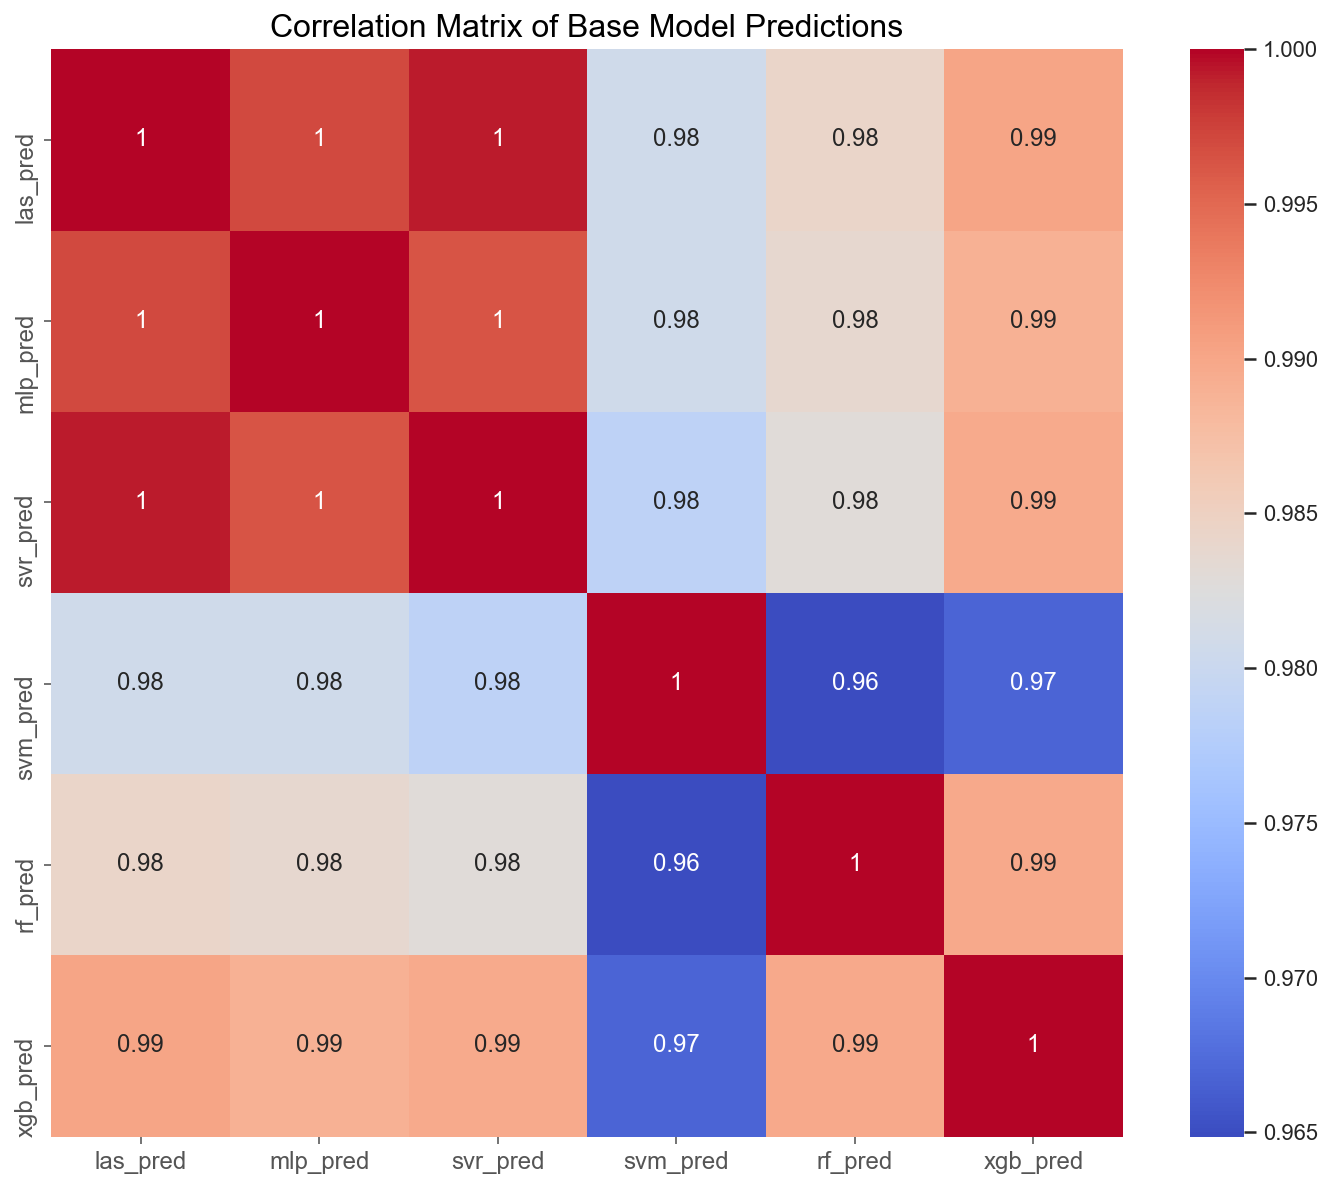

In [45]:
# Generate correlation matrix
fig, ax = plt.subplots(figsize=(12, 10))

sns.set(font_scale=1.0)
sns.heatmap(est_meta.corr(), annot=True, cmap='coolwarm', ax=ax)
ax.set_title("Correlation Matrix of Base Model Predictions", fontsize=16)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=12)
plt.show()

In [46]:
# Setting Linear Regression as the final stage meta model
meta = LinearRegression()

In [47]:
# Fitting the meta model to the predictions of the base models on the meta-training set, and y_meta
meta.fit(est_meta, y_meta)

LinearRegression()

# Predicting the Holdout Data

The base (first stage) and meta models are **not retrained** before making predictions on the holdout test set.

In [48]:
y_test

date
2014-07-02 11:00:00    56
2014-07-02 12:00:00    64
2014-07-02 13:00:00    66
2014-07-02 14:00:00    72
2014-07-02 15:00:00    78
                       ..
2014-12-31 18:00:00     8
2014-12-31 19:00:00    10
2014-12-31 20:00:00    10
2014-12-31 21:00:00     8
2014-12-31 22:00:00    12
Name: target, Length: 4380, dtype: int64

# Analytical Functions for Evaluations

In [49]:
def reg_scoring(X, y, meta, reg_dict):
    '''
    Objective: Cycles through a dictionary of trained models, using them to make predictions, scores those 
    predictions on MAE, MSE & RMSE, and generates DataFrames of the scores and model predictions respectively
    
    X: DataFrame containing the explanatory variables
    
    y: Target variable
    
    meta: Trained meta model
    
    reg_dict: Dictionary of trained/fitted models
    '''
    
    test1_scores = []
    test2_scores = []
    
    df_pred = pd.DataFrame(columns=reg_dict.keys()) # Columns of DF will accord with reg_dict keys
    
    # Loop through Dictionary items
    for key, reg in reg_dict.items():
        
        pred_y = reg.predict(X)
        df_pred[key] = pd.Series(pred_y).transpose()
        
        # Computing test scores for each model
        test1_scores.append(round(mean_absolute_error(y, pred_y), 4))
        test2_scores.append(round(mean_squared_error(y, pred_y, squared=False), 4))
        
    # Generate results DataFrame
    results = pd.DataFrame({'Model': list(reg_dict.keys()), 
                            'Mean Absolute Error': test1_scores,
                            'Root Mean Squared Error': test2_scores
                            })

    # Generate Stack Model's predictions, and test scores
    df_pred['Stack Model'] = meta.predict(df_pred) # Adding 'Stack Model' to DataFrame of predictions
    
    s1 = round(mean_absolute_error(y, df_pred['Stack Model']), 4)
    s2 = round(mean_squared_error(y, df_pred['Stack Model'], squared=False), 4)
    
    
    # Add target variable to the DataFrame of predictions
    df_pred['Target'] = y.tolist()
        
        
    # Inserting the Stack scores to the results DataFrame
    row1 = ['Stack Model', s1, s2]
    results.loc[len(results)] = row1
    
    return results, df_pred


In [50]:
def residual_plot(res):
    '''
    Objective: Generates four charts to assess the residuals of the model predictions -  
    a residual line chart through time; an ACF plot of residuals; a residual Q-Q plot; 
    and a kde histogram of residuals
    
    res: Residuals between the true target variable values and the model predictions
    '''
    # Standardizing residual values
    resid_standard = (res - res.mean()) / res.std()
    
    # Generate 2X2 chart plots
    figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

    ax[0, 0].plot(res)
    ax[0, 0].axhline(res.mean(), color='grey')
    ax[0, 0].set_title('Residuals')

    plot_acf(resid_standard, title='Correlogram', ax=ax[0, 1])

    sm.graphics.qqplot(res, line='45', fit=True, ax=ax[1, 0])
    ax[1, 0].set_title('Normal Q-Q')

    x = np.linspace(res.min(), res.max(), 1000)
    norm = stats.norm(loc=0, scale=res.std())
    sns.distplot(res, ax=ax[1, 1], label='kde estimate')
    ax[1, 1].plot(x, norm.pdf(x), label='normal distribution')
    ax[1, 1].legend()
    ax[1, 1].set_title('Distribution of Residuals')

    plt.show()
    

In [51]:
# Dictionary of TRAINED base models
reg_dict = {
    'Lasso Regression': gs_las,
    'Multi-Layer Perceptron': gs_mlp, 
    'Support Vector Regression': gs_svr,
    'Support Vector Machine': gs_svm,
    'Random Forest': gs_rf,
    'XG Boost': gs_xgb
}

# Comparative Test Scores & Plots

In [52]:
scores, df_pred = reg_scoring(X_test, y_test, meta, reg_dict)

In [53]:
# Generate Persistence Model's baseline scores
p1 = round(mean_absolute_error(y_test, df_holdout.pm25), 4)
p2 = round(mean_squared_error(y_test, df_holdout.pm25, squared=False), 4)

In [54]:
# Add Persistence Model's scores to the "scores" list
per_row = ['Persistence Model', p1, p2]
scores.loc[len(scores)] = per_row

In [55]:
scores

,Model,Mean Absolute Error,Root Mean Squared Error
0,Lasso Regression,10.9421,18.8500
1,Multi-Layer Perceptron,11.4326,19.1123
2,Support Vector Regression,11.8245,19.2449
3,Support Vector Machine,11.8154,19.9768
4,Random Forest,12.3886,20.5072
5,XG Boost,10.6753,18.8325
6,Stack Model,10.5323,18.6623
7,Persistence Model,11.1174,19.7566


The **Stack Model has the lowest (and best) MAE and RMSE scores** of all the models, and also demonstrates a **5-6% improvement** from the Persistence Model's scores.

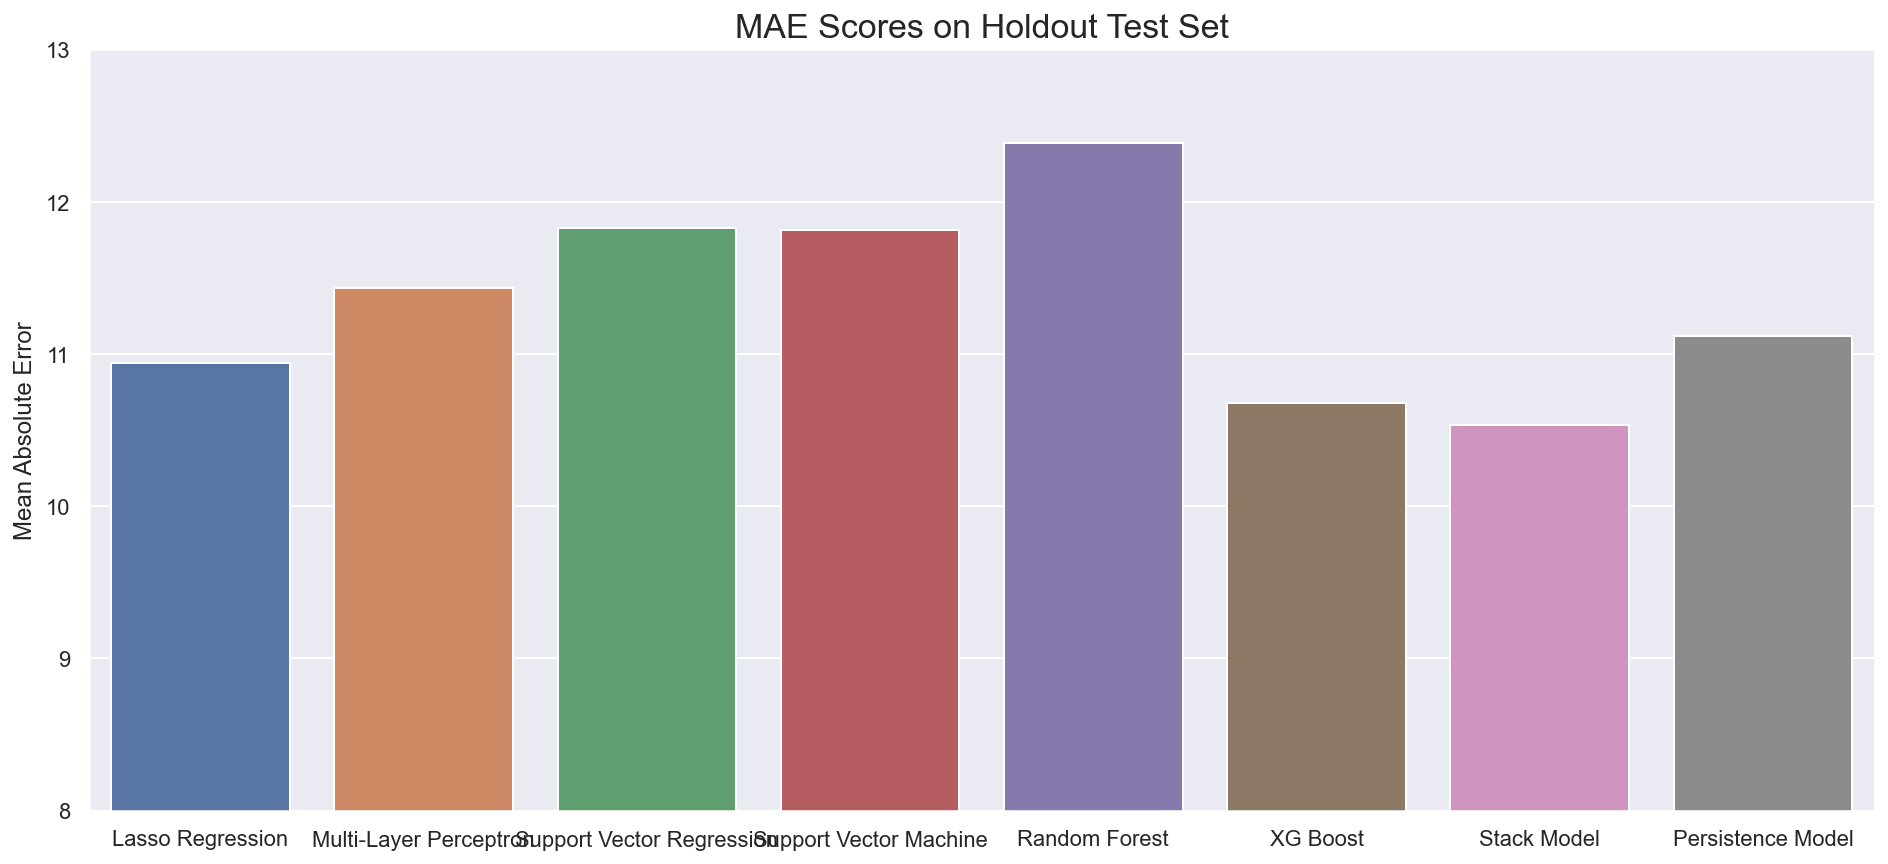

In [56]:
fig, ax = plt.subplots(figsize=(16,7))

sns.barplot(x='Model', y='Mean Absolute Error', data=scores, ax=ax)
ax.set(ylim=(8, 13))

ax.set_ylabel('Mean Absolute Error', size=12)
ax.set_xlabel('')
plt.title('MAE Scores on Holdout Test Set', fontsize=17);

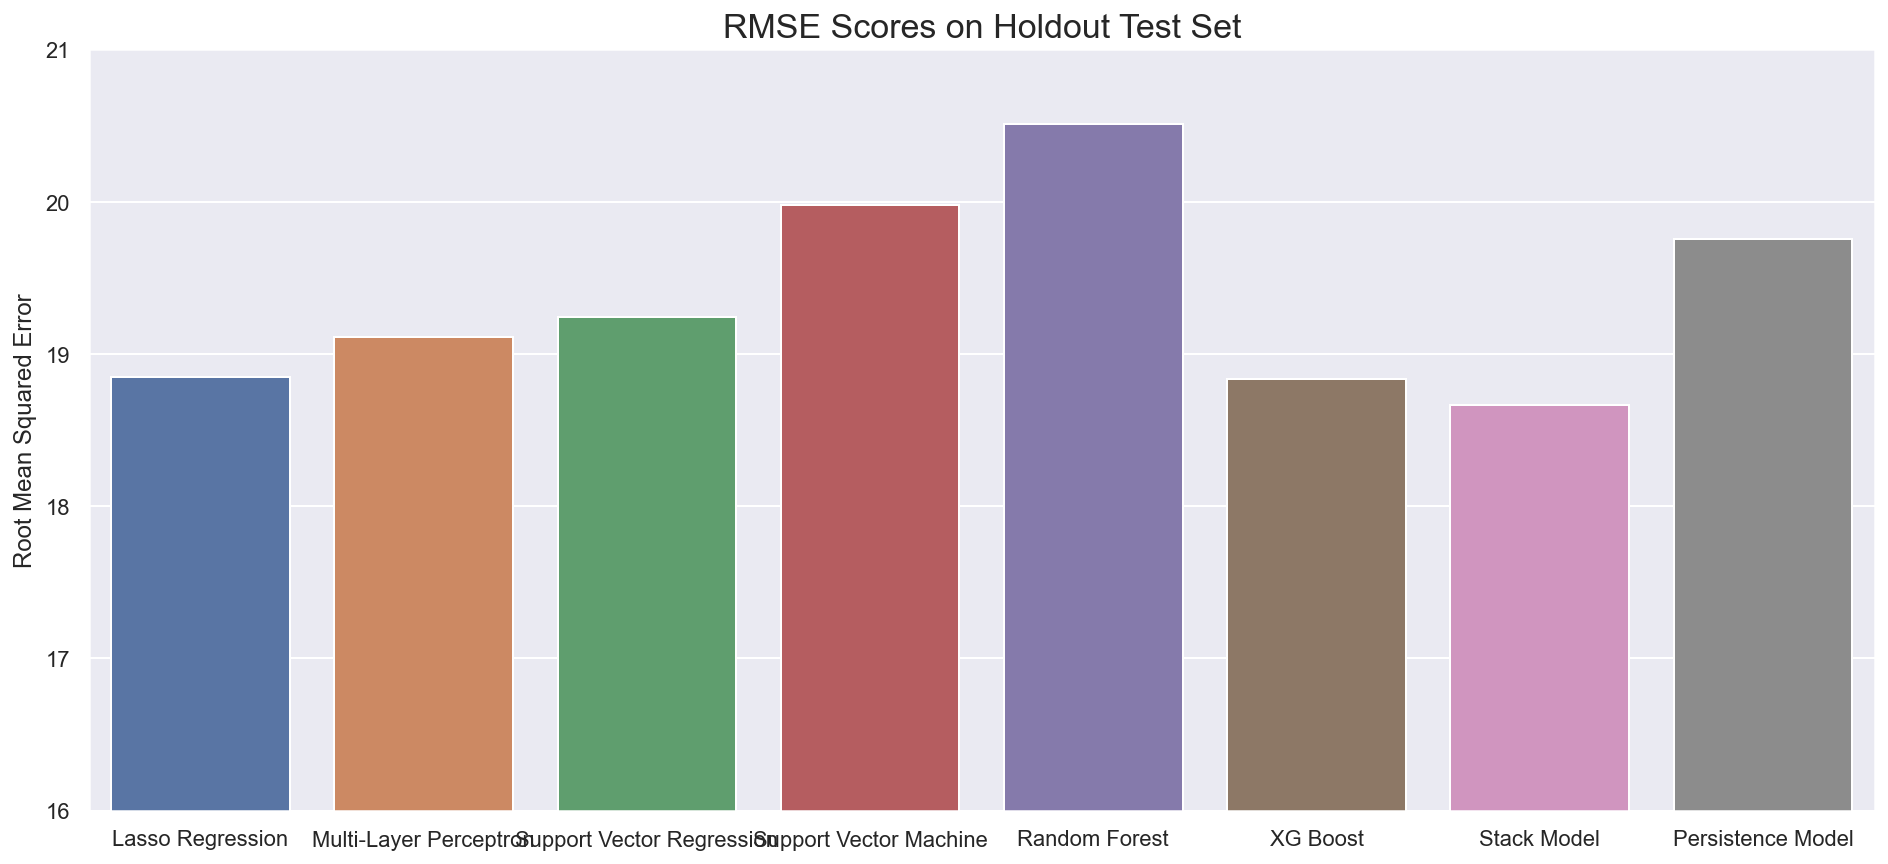

In [57]:
fig, ax = plt.subplots(figsize=(16,7))

sns.barplot(x='Model', y='Root Mean Squared Error', data=scores, ax=ax)
ax.set(ylim=(16, 21))

ax.set_ylabel('Root Mean Squared Error', size=12)
ax.set_xlabel('')
plt.title('RMSE Scores on Holdout Test Set', fontsize=17);

In [58]:
df_pred.index = df_holdout.index

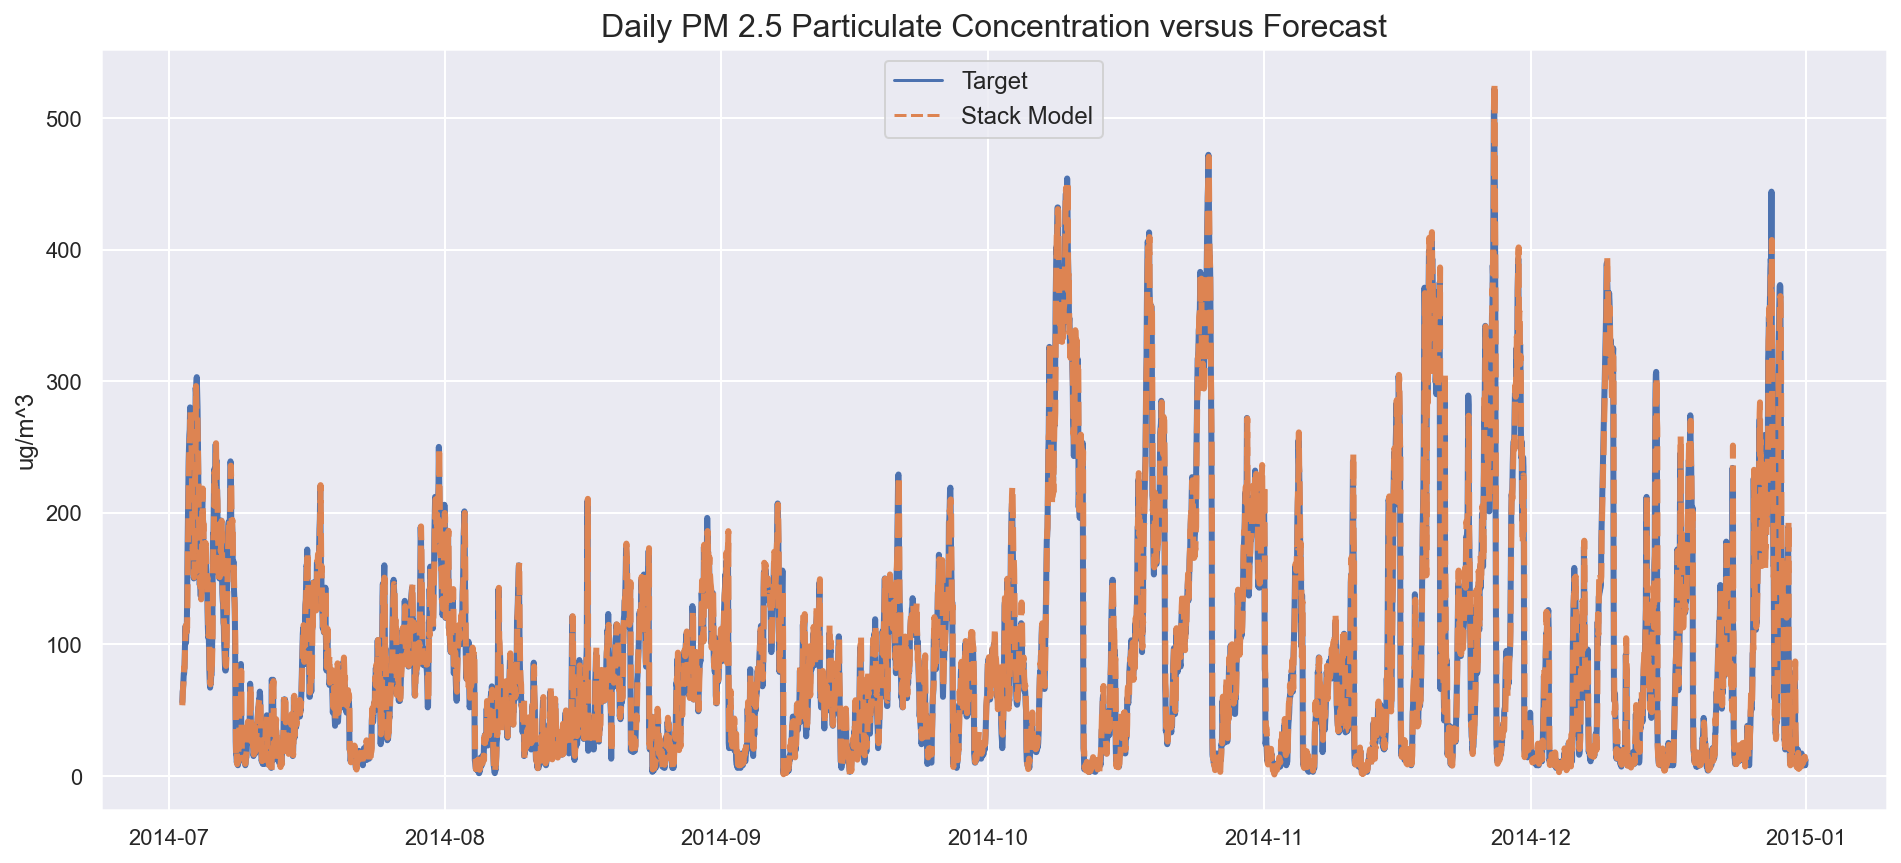

In [59]:
# Model predictions on test holdout data
fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=df_pred[['Target', 'Stack Model']], ax=ax, linewidth=3)
plt.legend(loc='upper center', fontsize=12)
plt.title('Daily PM 2.5 Particulate Concentration versus Forecast', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

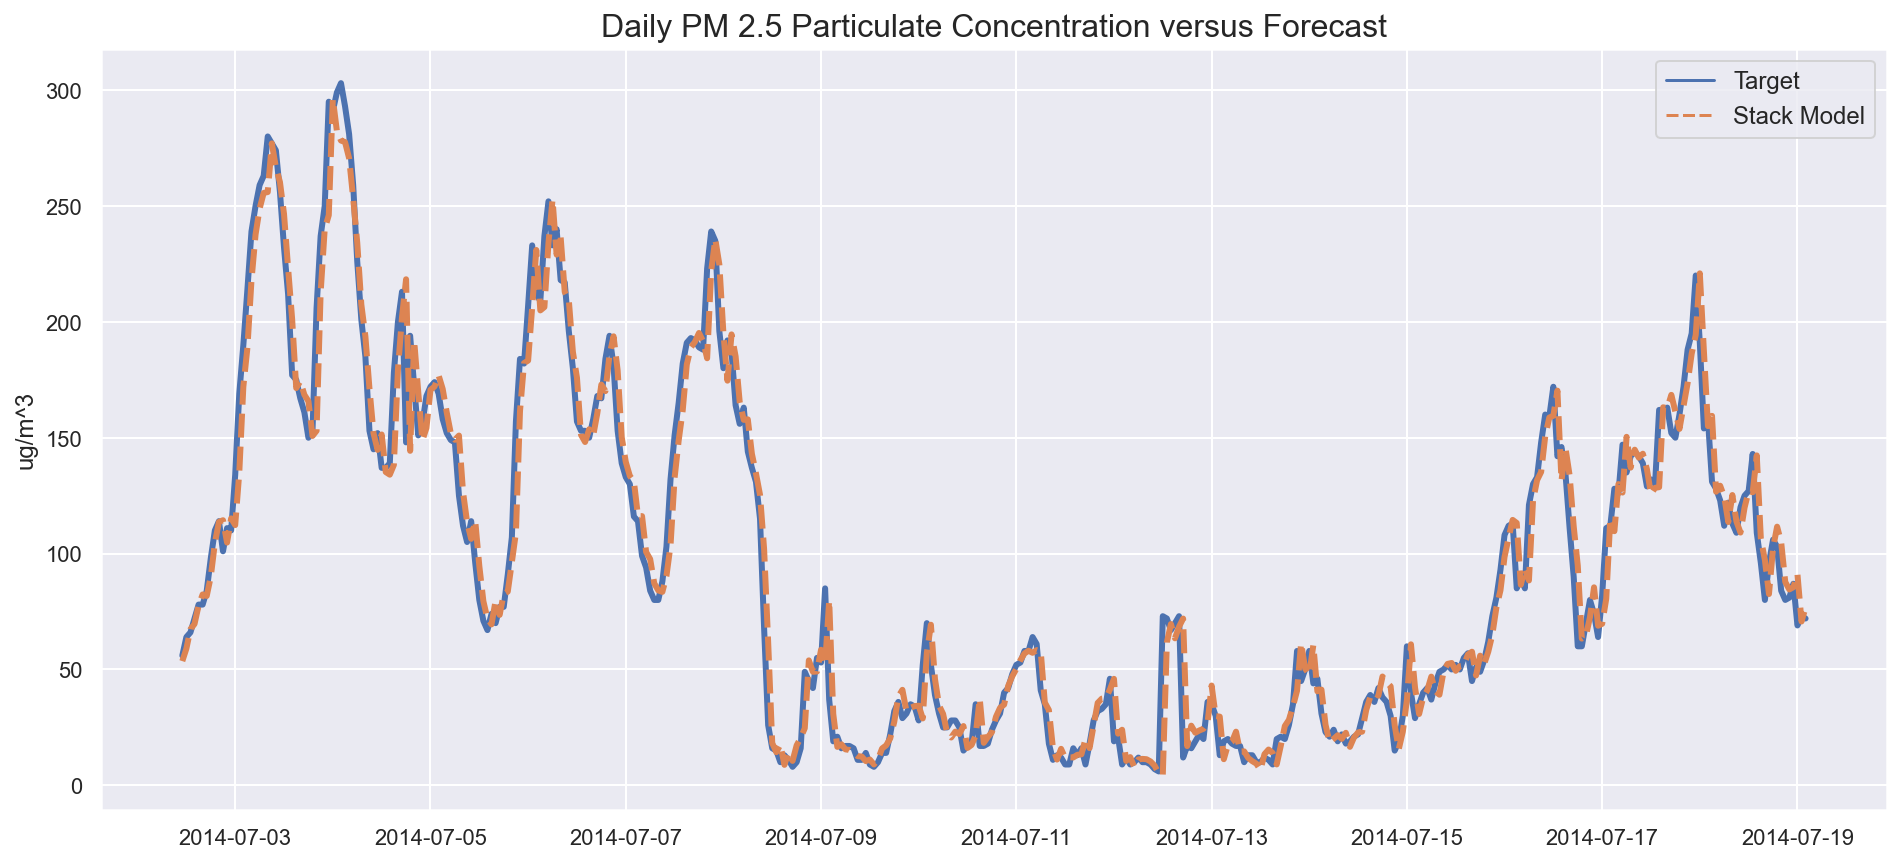

In [60]:
# Model predictions on first 400 observations of test holdout data
fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=df_pred[['Target', 'Stack Model']].iloc[:400], ax=ax, linewidth=3)
plt.legend(loc='upper right', fontsize=12)
plt.title('Daily PM 2.5 Particulate Concentration versus Forecast', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

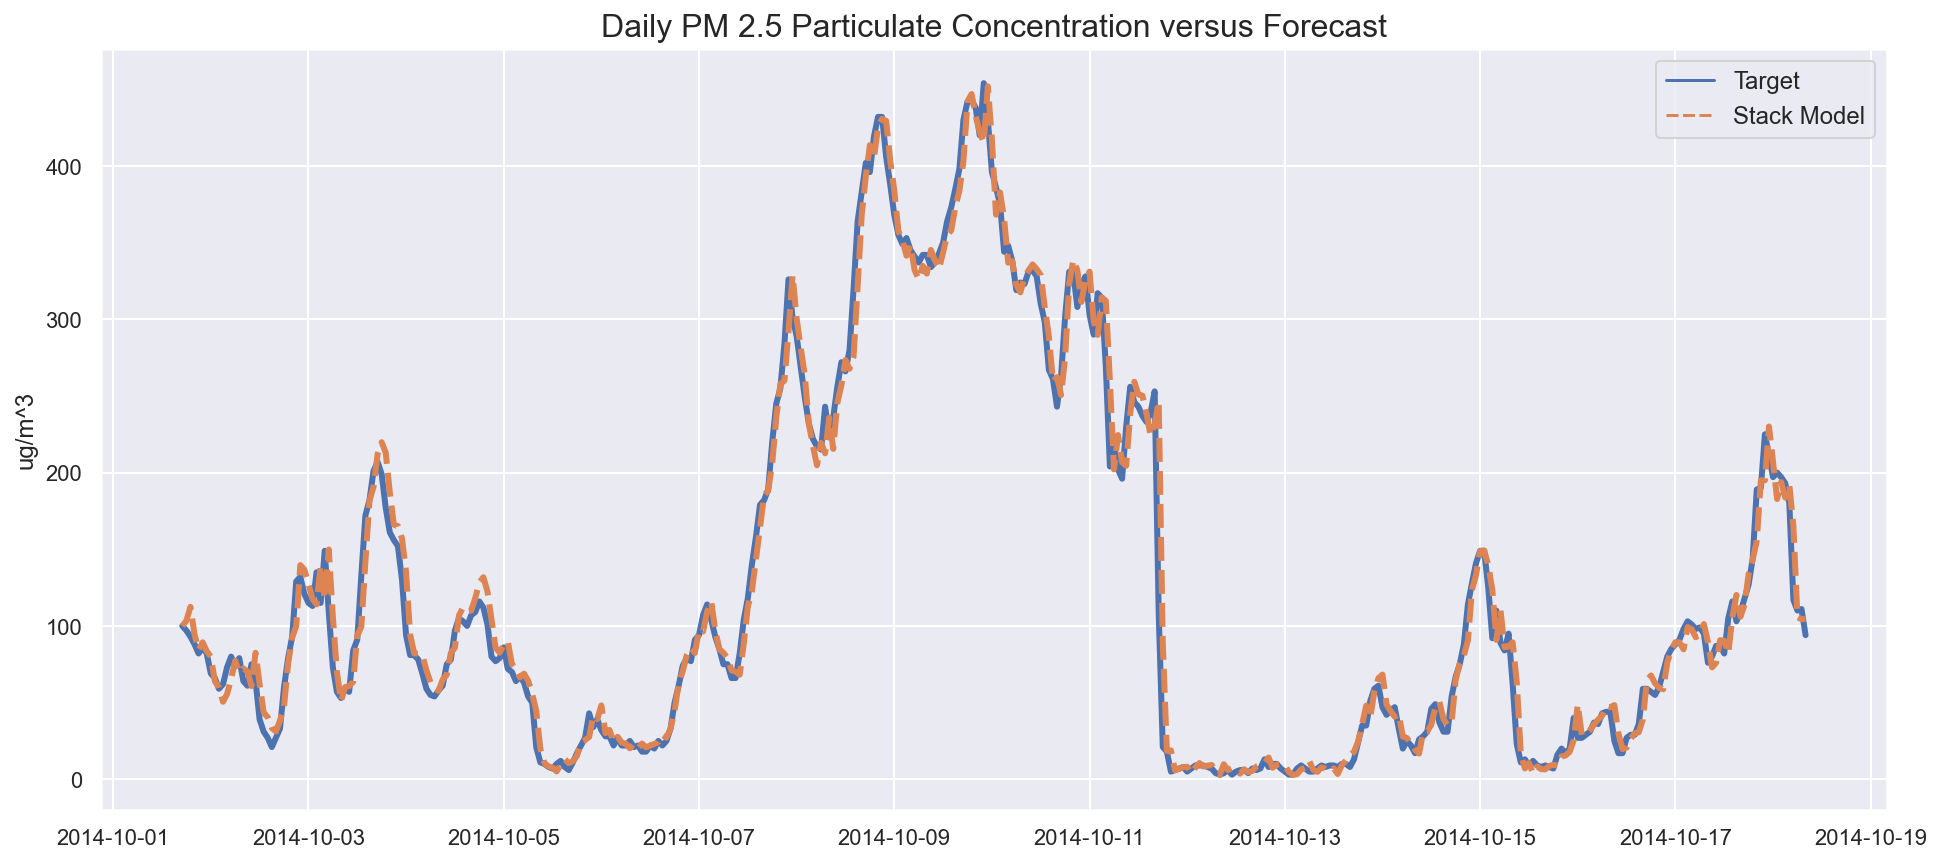

In [61]:
# Model predictions on middle 400 observations of test holdout data
fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=df_pred[['Target', 'Stack Model']].iloc[2190:2590], ax=ax, linewidth=3)
plt.legend(loc='upper right', fontsize=12)
plt.title('Daily PM 2.5 Particulate Concentration versus Forecast', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

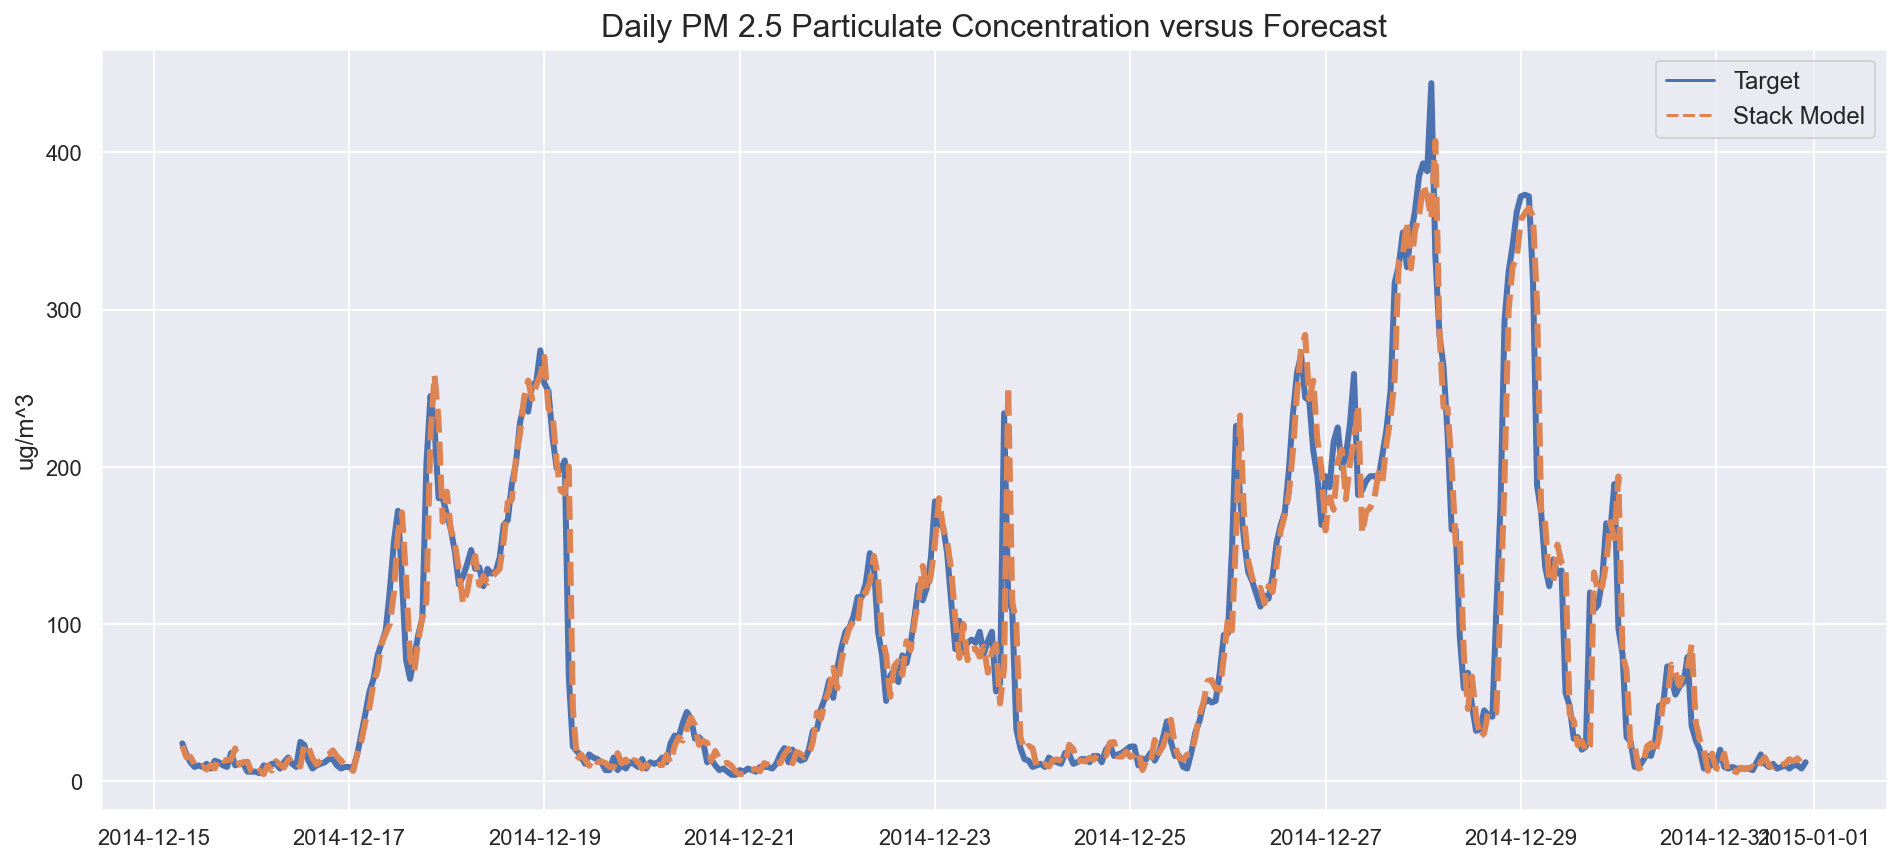

In [62]:
# Model predictions on last 400 observations of test holdout data
fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=df_pred[['Target', 'Stack Model']].iloc[-400:], ax=ax, linewidth=3)
plt.legend(loc='upper right', fontsize=12)
plt.title('Daily PM 2.5 Particulate Concentration versus Forecast', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

# Residual Plots

In [63]:
residual = df_pred['Target'] - df_pred['Stack Model']

C:\Users\camb7\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
C:\Users\camb7\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


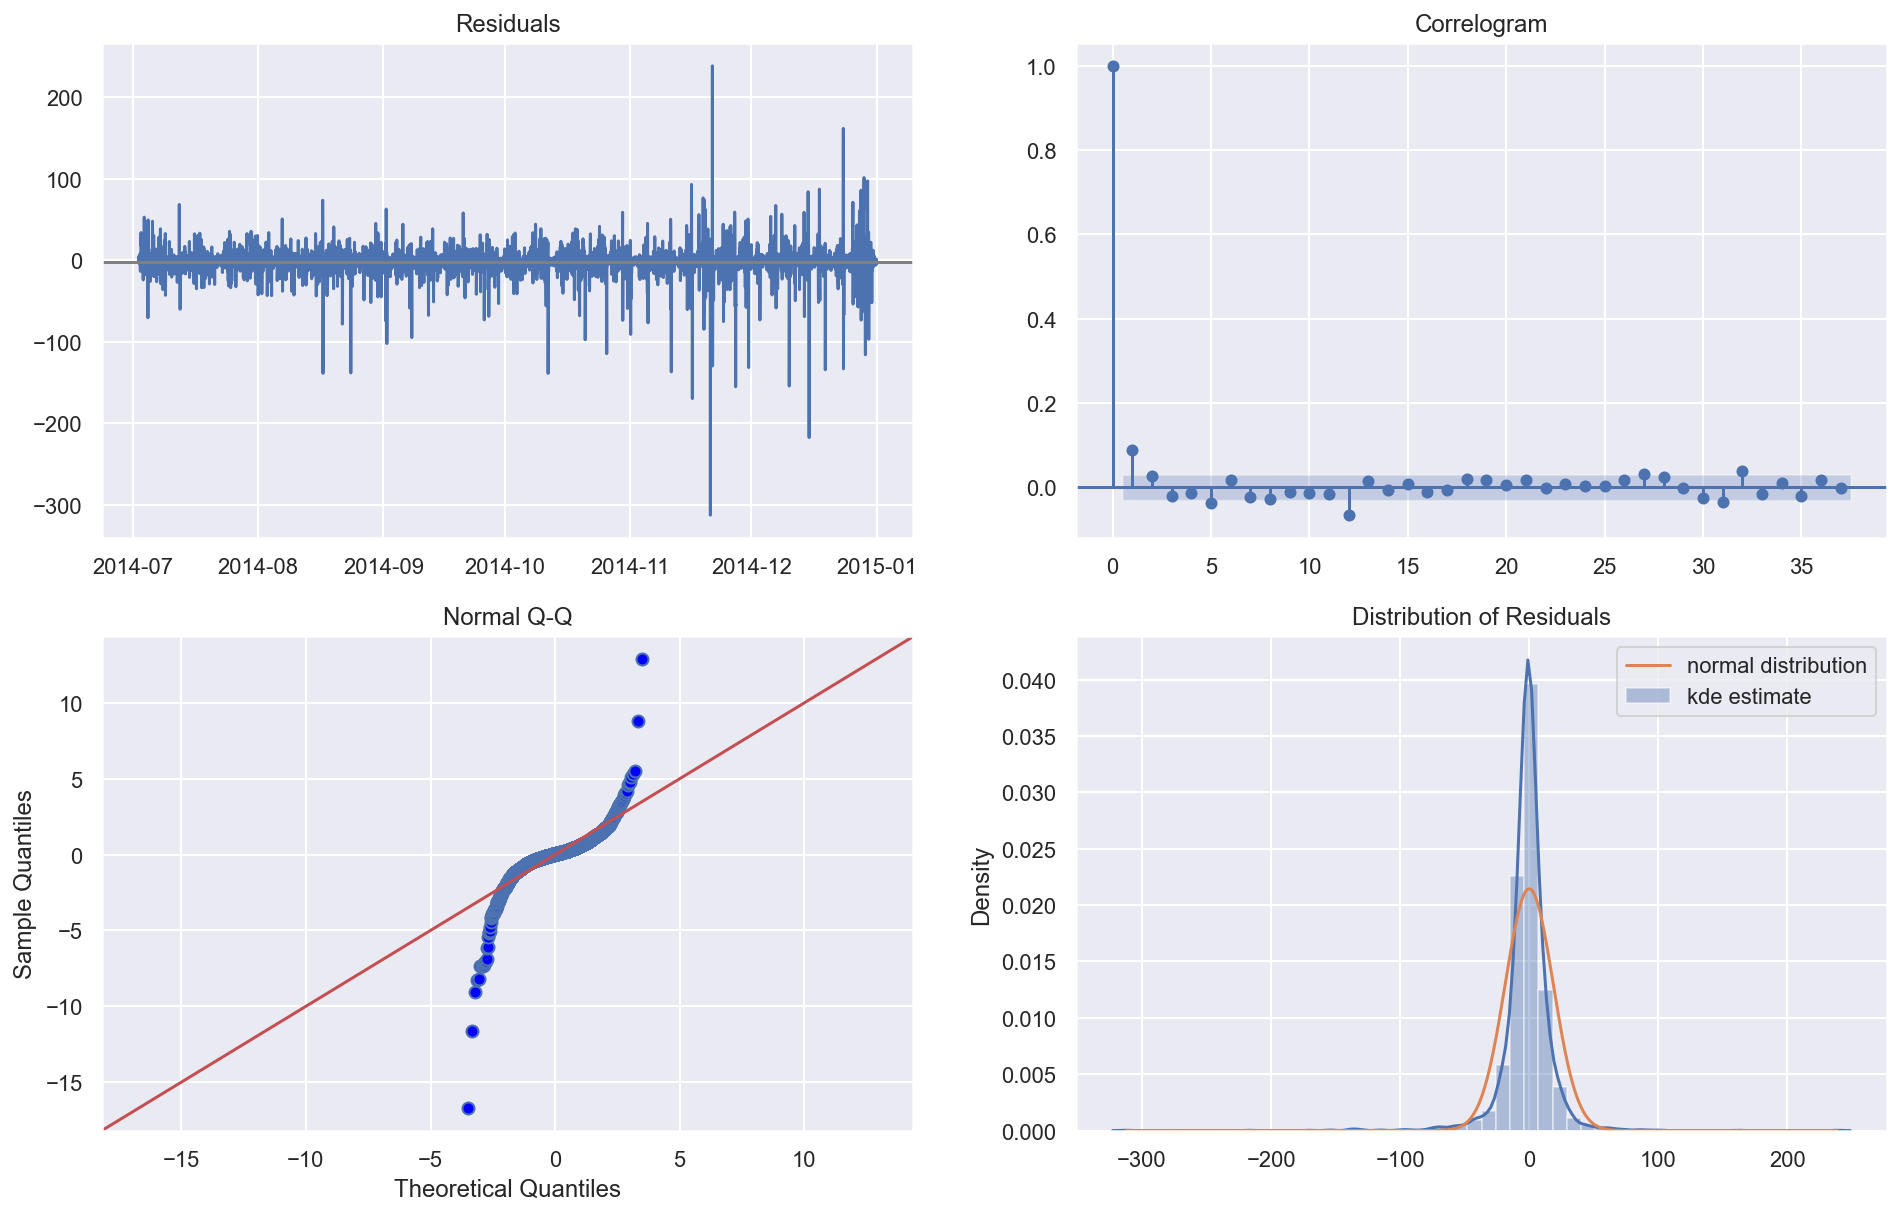

In [64]:
residual_plot(residual)

In [65]:
df_resid = df_pred.iloc[:,:-1].sub(df_pred['Target'], axis=0)

In [66]:
df_resid.describe()

,Lasso Regression,Multi-Layer Perceptron,Support Vector Regression,Support Vector Machine,Random Forest,XG Boost,Stack Model
count,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000
mean,0.707325,1.263858,1.527396,0.385434,2.056199,1.235502,1.451221
std,18.838860,19.072691,19.186417,19.975349,20.406136,18.794054,18.607894
min,-237.296381,-243.483577,-232.387546,-235.516937,-231.410667,-239.360538,-238.490606
25%,-6.144418,-6.250014,-6.362089,-7.460483,-5.558000,-5.290429,-5.381290
50%,0.839994,1.890746,1.692405,-0.409244,2.682667,1.365986,0.781043
75%,7.128667,8.120373,9.140576,7.065687,8.878000,6.766041,7.023703
max,299.029705,309.766973,299.415494,308.218062,304.936000,304.553864,312.366924


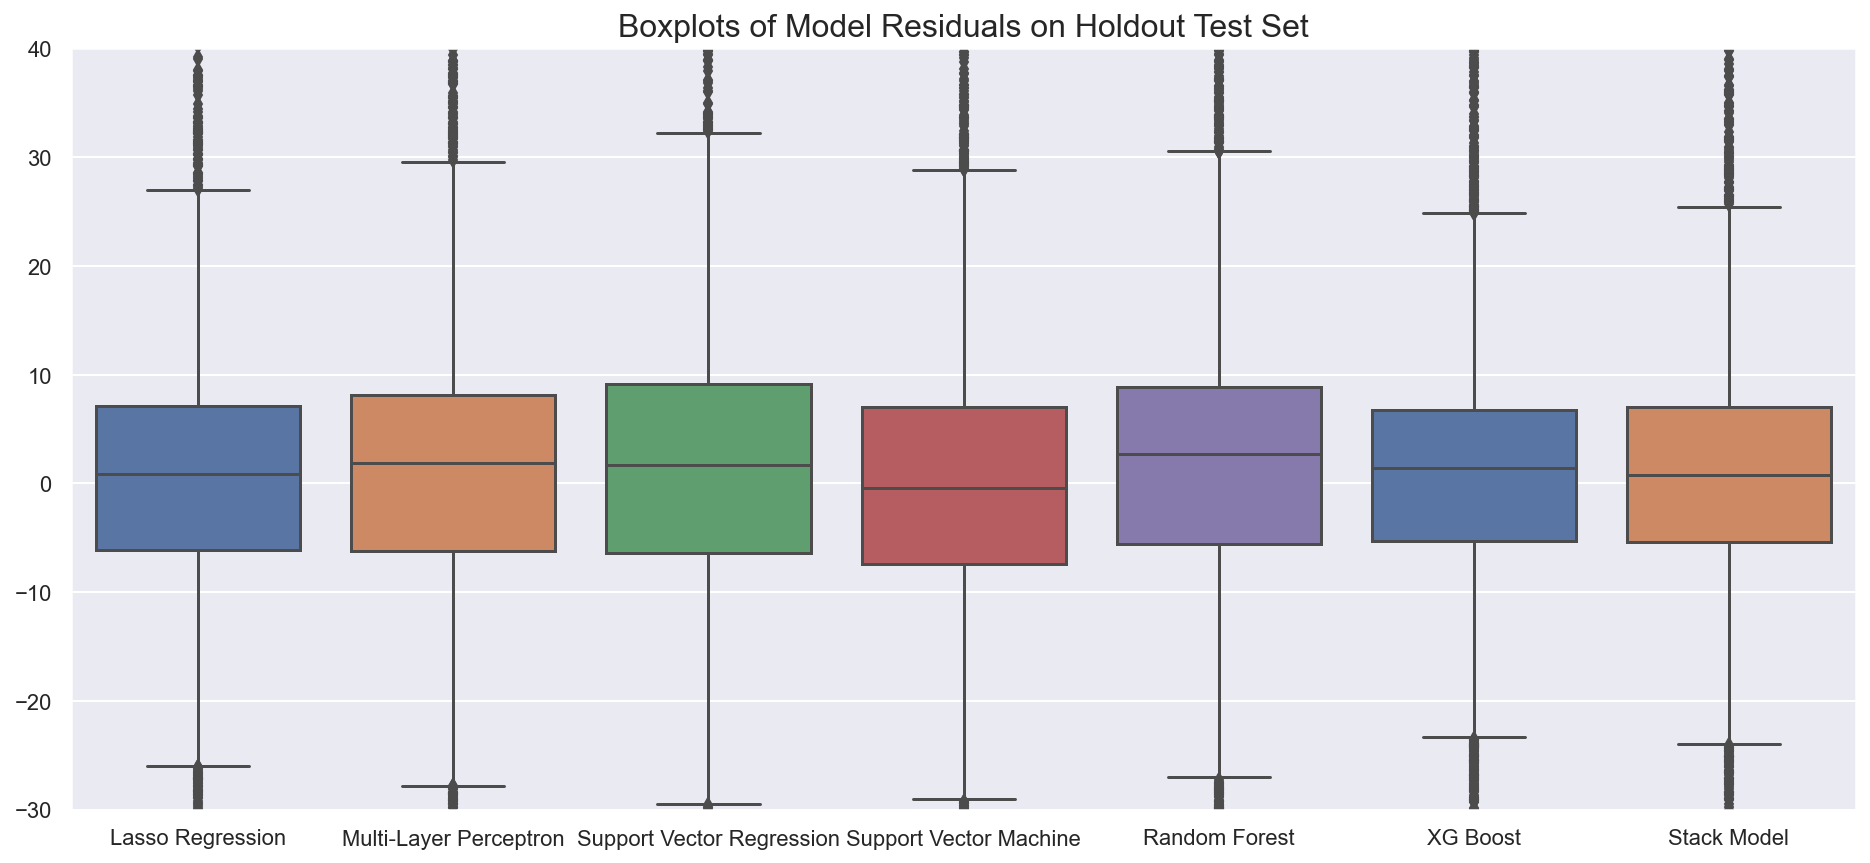

In [68]:
# Box-plots for the residuals across the base and meta models
plt.figure(figsize=(16,7))

ax=sns.boxplot(data=df_resid, orient='v', palette = sns.color_palette("deep", 5))
ax.set(ylim=(-30, 40))

plt.title('Boxplots of Model Residuals on Holdout Test Set', fontsize=16)
plt.xlabel('')
plt.ylabel('');